**Created by Sanskar Hasija**

**Model Soups 🍲 with Tensorflow + TFDS📊**

**20 February 2021**


# <center>MODEL SOUPS 🍲 WITH TENSORFLOW + TFDS📊</center>
## <center>If you find this notebook useful, support with an upvote👍</center>

# Table of Contents
<a id="toc"></a>
[1. Introduction  ](#1)<br>
[2. Imports](#2)<br>
[3. Uniform Soup ](#3)<br>
[4. Greedy Soup ](#4)<br>
[5. Model Soups on Image Data](#5)<br>
[6. Model Soups on Tabular Data](#6)<br>
[7. Model Soups on Text Data](#7)<br>
[8. Model Soups on Time-Series Data](#8)<br>

<a id="1"></a>
# **<center><span style="color:#00BFC4;">Introduction </span></center>**

## <span style="color:#e76f51;"> Notebook overview : </span>
* This notebook is an end-to-end implementation and code replication of the paper titled ["Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time"](https://arxiv.org/abs/2203.05482).
* Model Soups is currently ranked the second-best state-of-the-art benchmark on the ImageNet Dataset. Check full rankings [here](https://paperswithcode.com/sota/image-classification-on-imagenet).
* The code is reusable and can be used to create model soups for any TensorFlow model.
* This notebook includes two model souping techniques namely Uniform Soup and Greedy Soup as  discussed in the research paper.
* Model Souping is performed on four major data formats - Image, Tabular, Text, and Time Series. TF.Data API is used for building Image, Text and Time Series Dataset.


<h2> <span style="color:#e76f51;"> Model Soups: </span></h2> 
<center><img 

<center><img src="https://raw.githubusercontent.com/sanskar-hasija/kaggle/main/images/uniform_soup.png" width="550" height="200" /></center><br>

* Model Soups is an alternative technique to ensembling which includes averaging different trained model weights without incurring any additional inference or memory costs.
* Model soups can be analogical compared to an ensemble of n models for training but inferencing with only one model using 1/n of the time of that of the ensemble's inference.
* Model Soup comprises two main steps.
    * Saving trained model during hyperparameter tuning, and optimization.
    * Averaging trained model's weights using either Uniform Soup or Greedy Soup.

    
<h2> <span style="color:#e76f51;">TF.data </span></h2> 
<center><img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data.png" width="800" height="200" /></center><br>



* TF.DATA API is used for building efficient input pipelines which can handle large amounts of data and perform complex data transformations. <br>
* TF.DATA API has provisions for handling different data formats.<br>

Check out tf.data guide and  documentation - [here](https://www.tensorflow.org/guide/data).<br>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Imports </span></center> 
<a id="2"></a>

In [1]:
!pip install -q tensorflow==2.4.1 
## downgrading tensorflow due to "Cleanup Called" issue with tfds datasets

import os
import random
import numpy as np
import pandas as pd 
import tensorflow as tf 
from datasets import Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, DataCollatorWithPadding

import gc
gc.collect()

import warnings
warnings.filterwarnings('ignore')

from transformers import logging
logging.set_verbosity_error()

from IPython.display import clear_output
clear_output()

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# **<center><span style="color:#00BFC4;">Uniform Soup </span></center>** 


#### In Uniform Soup, all trained model's weights are average irrespective of each model's performance on the held-out validation set.


In [2]:
def uniform_soup(model_paths, test_ds, model_fun, evaluate_fun, disable_tqdm = False):
    """
    Returns Uniform Soup model and accuracy on test set 
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    disable_tqdm : Bool, Wheter to disable TQDM Progress bar or not
    """
    
    soups = []
    ## Instantiating model
    
    tf.keras.backend.clear_session()
    model = model_fun()
    
    ## Iterating Over all models 
    for path in tqdm(model_paths, disable=disable_tqdm):
        
        ## loading model wieghts 
        model.load_weights(path)
        
        ## Adding model weights in soup list
        soup = [np.array(weights) for weights in model.weights]
        soups.append(soup)
        
    ## Averaing all weights 
    mean_soup = np.array(soups).mean(axis = 0)
    
    ## Replacing model's weight with Unifrom Soup Weights
    for w1, w2 in zip(model.weights, mean_soup ):
        tf.keras.backend.set_value(w1, w2)
        
    ## evaluating uniform soup performance   
    accuracy =  evaluate_fun(model, test_ds)
    return model, accuracy

##### <center><span style="color:#e76f51;">NOTE ON UNIFORM SOUP</span></center>
##### <span style="color:#e76f51;">In this notebook all the wieghts are intialized randomly to boost greedy soup score. Therefore, Uniform Soup model will perofm poorly or will be  equivalent to random guessing. This can be changed by setting up a random set for weigths initialization. </span>

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# **<center><span style="color:#00BFC4;">Greedy Soup </span></center>** 


####  In Greedy Soup, all trained models are first sorted in descending order, followed by adding weights to the best performing model if the overall soup's performance increases.


<center><img src="https://raw.githubusercontent.com/sanskar-hasija/kaggle/main/images/greedy_soup.png" width="750" height="200" /></center><br>


In [3]:
def greedy_soup(model_paths, test_ds, model_fun, evaluate_fun):
    """
    Returns Greedy Soup model and accuracy on test set 
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    """
    ## Creating intial soup with best performing model 
    soups =  [model_paths[0]]
    
    ## Instantiating model
    
    tf.keras.backend.clear_session()
    model = model_fun()
    
    ## Loading best performing model's weights 
    model.load_weights(model_paths[0])
    
    ## Scoirng best performing model on test set 
    score_final = evaluate_fun(model,test_ds)
    
    ## Iterating over the remaining models 
    for path in tqdm(model_paths[1:]):
        
        ## Creating a temp soup 
        temp_soup =  soups.copy()
        temp_soup.append(path)
        
        ## Getting score from temp soup
        model, score = uniform_soup(temp_soup,test_ds,model_fun, evaluate_fun, disable_tqdm= True)
        
        ## Conditioning current model for appneding in main soup
        ## if score from the temp soup is more than best perofming model
        ## the temp soup path is appended to main soup 
        if score > score_final:
            score_final = score
            soups.append(path)

    return model, score_final

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Soups on Image Data</span></center> 
<a id="5"></a>

## <span style="color:#e76f51;"> Setting up TF.data Pipeline  : </span>


<center><img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data-simple-pipeline.png" width="800" height="300" />


📌 tf.data API is used for building efficient input pipelines which can handle large amounts of data and perform complex data transformations . tf.data API has provisions for handling different data formats.
    
📌The tf.data API enables you to build complex input pipelines from simple, reusable pieces. The tf.data API also makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

📌The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.


 
**Transformations :**

* The Dataset object can be transformed into a new Dataset by chaining method calls on the tf.data.Dataset object . Some of the transformations which can be applied are Dataset.map() , Dataset.batch() , Dataset.shuffle() , Dataset.prefetch() .

* The Dataset object is a Python iterable which  it possible to consume its elements using a for loop .

<center><img src="https://drive.google.com/uc?id=1x383ghyybTV0jQqBSlHDEc8FWD8AqaHz" width="550" height="500" /></center>

##### For Model Soups with image data, CIFAR10 Dataset is used in this notebook. 
##### CIFAR10 dataset along with 100+ ML datasets can be explored and downloaded from the [TensorFlow Dataset Catalog](https://www.tensorflow.org/datasets/catalog/overview).

In [4]:
## Mapping utility functions 


def normalize(image, label):
    """
    TFDS map function to normalize images
    """
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    return image, label

def augment1(image, label):
    """
    TFDS map function to augument images randomly
    """
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 

def augment2(image, label):
    """
    TFDS map function to augument images randomly
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 

In [5]:
AUTO = tf.data.AUTOTUNE
ignore_order = tf.data.Options()

class image_config:
    BATCH_SIZE = 64
    SHUFFLE_BUFFER = 1024 
    NUM_MODELS = 20

## download data in local drives and instantiating tfds datasets 
cifar_train, cifar_test = tfds.load("cifar10", split= ["train", "test"],  as_supervised=True)


## normaling images
cifar_train = cifar_train.map(normalize, num_parallel_calls=AUTO)
## shuffling training images
cifar_train = cifar_train.shuffle(image_config.SHUFFLE_BUFFER)
## batching training images
cifar_train = cifar_train.batch(image_config.BATCH_SIZE, drop_remainder= True)
cifar_train = cifar_train.prefetch(AUTO)



## extracting labels for later use
test_ids_ds = cifar_test.map(lambda x,y : y)
cifar_test_labels = next(iter(test_ids_ds.batch(len(test_ids_ds)))).numpy()



## normalizing test images
cifar_test = cifar_test.map(normalize, num_parallel_calls=AUTO)
## batching test images
cifar_test = cifar_test.batch(image_config.BATCH_SIZE, drop_remainder=False)
cifar_test = cifar_test.prefetch(AUTO)
clear_output()

## <span style="color:#e76f51;"> Image Data Training Utility functions   : </span>

In [6]:
def create_cifar_model(weights = "imagenet"):
    """
    Returns ResNet50V2 Model for Transfer Learning 
    Args:
    weights : weights to load for ResNet50V2 Base Model
    """
        
    ## ResNet50V2 as Base Model ( Feature Extractor)
    feature_extractor = tf.keras.applications.ResNet50V2(input_shape=(32,32, 3),
                                               include_top=False,
                                               weights=weights)
    model= tf.keras.Sequential()
    model.add(feature_extractor) 
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024,activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(512,activation='relu')) 
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    return model

def cifar_training(train_ds, 
                   test_ds,
                   epochs, 
                   learning_rate, 
                   weight_decay,
                   aug_map= None,
                   save_dir = "cifar/"):
    """
    Returns Saved trained model's path and test evaluation score
    Args:
    train_ds : Train Dataset in tfds format.
    test_ds : Test Dataset in tfds format.
    epochs : Int, Trainig Epochs count.
    learning_rate : Float, Training Learning Rate
    weight_decay : Float, AdamW optimizer Weight Decay
    aug_map: Mapping function for augmentting train_ds
    save_dir : Str, Model Save Directory Prefix
    """
    ## Creating directory for saving models
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    
    ## Augumentation Check
    is_aug = False
    if aug_map is not None:
        train_ds = train_ds.unbatch().map(aug_map).batch(image_config.BATCH_SIZE).prefetch(AUTO)
        is_aug = True
        
        
    ## AdamW Optimizer Setup    
    adamw_optimizer = tfa.optimizers.AdamW(weight_decay= weight_decay,
                                     learning_rate= learning_rate)
    
    ## Instantiating model
    tf.keras.backend.clear_session()
    model = create_cifar_model()
    
    ## Compiling Model
    model.compile(
            
            optimizer = adamw_optimizer,
            loss = "sparse_categorical_crossentropy",
            metrics = ["accuracy"]
        )
    
    
    ## Training Model
    model.fit(
        train_ds,
        epochs = epochs,
        verbose = 0
    )
    
    ## Evaluating Model
    test_loss , test_score  = model.evaluate(test_ds, verbose = 1 )
    
    ## Saving Trained Model
    model_save_path = save_dir + "cifar-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) +  "_" + str(int(is_aug)) + ".h5"
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## if model with same parameter already exists
        model_save_path = save_dir + "cifar-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + str(random.choice(np.arange(0,1000))) +  ".h5"
        model.save_weights(model_save_path)
        
    ## Clearing GPU memory
    ## Clearing GPU memory
    del model 
    gc.collect()
    return model_save_path, test_score

def cifar_eval(model,test_ds):
    """
    Returns Accuracy of model on test set 
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    
    preds = model.predict(test_ds)
    preds = preds.argmax(axis = 1 )
    acc = np.sum(preds == cifar_test_labels) / len(cifar_test_labels)
    return acc

## <span style="color:#e76f51;"> Image Data Training : </span>

In [7]:
epochs = [8,10,12]
learning_rate = [1e-4, 1e-5, 5e-5]
weight_decay = [1e-4, 1e-4, 1e-5]
augments = [None, augment1, augment2]

## Creating parameters dictonary for 
## hyperparameter tuning 
parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
    "aug_map" : random.choice(augments) 
} for count in range(image_config.NUM_MODELS)]
cifar_params = pd.DataFrame(parameters)


model_paths = []
test_scores = []

for params in tqdm(parameters):
    model_save_path, test_score = cifar_training(cifar_train, 
                                                 cifar_test,
                                                 params["epochs"], 
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 params["aug_map"],
                                                 save_dir = "cifar/")
    
    model_paths.append(model_save_path)
    test_scores.append(test_score)

## saving scores and model paths to dataframe    
cifar_params["paths"] = model_paths
cifar_params["scores"] = test_scores

## soring scores in descending order
cifar_params.sort_values(by = "scores", ascending= False, inplace = True)
cifar_params.reset_index(drop= True, inplace = True)

## saving params with respective scores and model paths
cifar_params.to_csv("cifar_params.csv", index = False)


  0%|          | 0/20 [00:00<?, ?it/s]

94674944/94668760 [==============================] - 1s 0us/step


2022-06-22 09:23:54.429907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-22 09:23:55.270453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-22 09:23:55.279617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


157/157 [==============================] - 3s 14ms/step - loss: 0.7097 - accuracy: 0.7862


## <span style="color:#e76f51;"> Uniform Soups on Image Data: </span>

In [8]:
unifrom_soup_model, uniform_soup_acc = uniform_soup(
    cifar_params["paths"].values, 
    cifar_test, 
    create_cifar_model, 
    cifar_eval
)
print("Accuracy of Uniform Soup:", uniform_soup_acc )

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of Uniform Soup: 0.1


## <span style="color:#e76f51;"> Greedy Soups on Image Data: </span>

In [9]:
greedy_soup_model, greedy_soup_acc = greedy_soup(
    cifar_params["paths"].values,
    cifar_test,
    create_cifar_model,
    cifar_eval
)
print("Accuracy of Uniform Soup:", greedy_soup_acc)

  0%|          | 0/19 [00:00<?, ?it/s]

Accuracy of Uniform Soup: 0.797


## <span style="color:#e76f51;"> Uniform and Greedy Soups Visualizaiton and Comparison: </span>

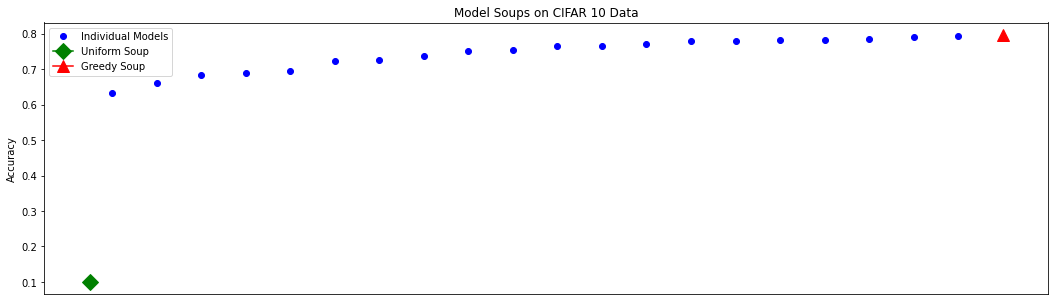

In [10]:
uniform_soup_pos = cifar_params[cifar_params["scores"].values[::-1] > uniform_soup_acc].index[0] - 0.5

fig, ax = plt.subplots(figsize = (18,5))
plt.plot( cifar_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( uniform_soup_pos,uniform_soup_acc,  marker= "D", color = "green", markersize = 12, label = "Uniform Soup")
plt.plot( len(cifar_params), greedy_soup_acc,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("Accuracy")
plt.title("Model Soups on CIFAR 10 Data")
plt.legend();

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Soups on Tabular Data</span></center> 
<a id="6"></a>

#### For Tabular data, Famous Titanic Competition Data is used. The Target variable is binary and represents wheter a passenger survived the Titanic Crash or not.
####  Link to Competition Data - https://www.kaggle.com/competitions/titanic/data

## <span style="color:#e76f51;"> Titanic Data Loading and Processing    : </span>

In [11]:
## All Data Processing is taken from one of my other 
## notebook on the same competition. 
## Link to notebook - https://www.kaggle.com/code/odins0n/titanic-27-different-models-comparison


train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv('../input/titanic/test.csv')

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

def checkNull_fillData(df):
    for col in df.columns:
        if len(df.loc[df[col].isnull() == True]) != 0:
            if df[col].dtype == "float64" or df[col].dtype == "int64":
                df.loc[df[col].isnull() == True,col] = df[col].mean()
            else:
                df.loc[df[col].isnull() == True,col] = df[col].mode()[0]
                
checkNull_fillData(train)
checkNull_fillData(test)

str_list = [] 
num_list = []
for colname, colvalue in train.iteritems():
    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)
        
train = pd.get_dummies(train, columns=str_list)
test = pd.get_dummies(test, columns=str_list)

train_X = train.drop("Survived" , axis =1 )
train_y = train["Survived"]

X_train , X_test , y_train , y_test = train_test_split(train_X , train_y, random_state = 12 ,test_size =0.33)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class tabular_config:
    NUM_MODELS = 20

## <span style="color:#e76f51;"> Tabular Data Training : </span>

In [12]:
def create_titanic_model(dropout_prob = 0):
    """
    Returns TensorFlow DNN Model
    Args:
    dropout_prob : Dropout Probability for Dropout Layers
    """    
        
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape = (8)))
    model.add(tf.keras.layers.Dense(1024,activation='relu')) 
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.Dense(512,activation='relu')) 
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    return model

def titanic_training(train_ds, 
                   test_ds,
                   epochs, 
                   learning_rate, 
                   weight_decay,
                   dropout_prob,
                   save_dir = "titanic/"):
    """
    Returns Saved trained model's path and test evaluation score
    Args:
    train_ds : Train Dataset in tfds format.
    test_ds : Test Dataset in tfds format.
    epochs : Int, Trainig Epochs count.
    learning_rate : Float, Training Learning Rate
    weight_decay : Float, AdamW optimizer Weight Decay
    save_dir : Str, Model Save Directory Prefix
    """
    ## Creating directory for saving models
    
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    ## AdamW Optimizer Setup    
    adamw_optimizer = tfa.optimizers.AdamW(weight_decay= weight_decay,
                                     learning_rate= learning_rate)
    
    ## Instantiating model
    tf.keras.backend.clear_session()
    model = create_titanic_model(dropout_prob)
    
    ## Compiling Model
    model.compile(
            
            optimizer = adamw_optimizer,
            loss = "binary_crossentropy",
            metrics = ["accuracy"]
        )
    
    ## Training Model
    model.fit(
        train_ds[0],
        train_ds[1],
        epochs = epochs,
        verbose = 0
    )
    
    ## Evaluating Model
    test_loss , test_score  = model.evaluate(test_ds[0], test_ds[1], verbose = 1 )
    
    ## Saving Trained Model
    model_save_path =save_dir +  save_dir + "titanic-"  +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + ".h5"
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## if model with same parameter already exists
        model_save_path = save_dir + "titanic-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + str(random.choice(np.arange(0,1000))) +  ".h5"
        model.save_weights(model_save_path)
        
    ## Clearing GPU memory
    del model 
    gc.collect()
    return model_save_path, test_score

def titanic_eval(model,test_ds):
    """
    Returns Accuracy of model on test set 
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    preds = model.predict(test_ds[0])
    preds = preds.squeeze().round().astype("int")
    acc = np.sum(preds == test_ds[1]) / len(test_ds[1])
    return acc

In [13]:
epochs = [20,25,30]
learning_rate = [1e-2, 1e-3, 1e-4, 2e-5, 5e-5]
weight_decay = [1e-4, 1e-4, 1e-5]
dropout_probs = [0.2,0.3,0.4]


## Creating parameters dictonary for 
## hyperparameter tuning 
parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
    "dropout_prob" : random.choice(dropout_probs) 
} for count in range(tabular_config.NUM_MODELS)]

## creating a dataframe for parameters
titanic_params = pd.DataFrame(parameters)

model_paths = []
test_scores = []


## Training models with different parameters
for params in tqdm(parameters):
    model_save_path, test_score = titanic_training((X_train, y_train), 
                                                 (X_test, y_test),
                                                 params["epochs"], 
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 params["dropout_prob"],
                                                 save_dir = "titanic/")
    
    model_paths.append(model_save_path)
    test_scores.append(test_score)

## saving scores and model paths to dataframe
titanic_params["paths"] = model_paths
titanic_params["scores"] = test_scores


## soring scores in descending order
titanic_params.sort_values(by = "scores", ascending= False, inplace = True)
titanic_params.reset_index(drop = True, inplace = True)

## saving params with respective scores and model paths
titanic_params.to_csv("titanic_params.csv", index = False)


  0%|          | 0/20 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.7492


## <span style="color:#e76f51;"> Uniform Soups on Tabular Data: </span>

In [14]:
unifrom_soup_model, uniform_soup_acc = uniform_soup(
    titanic_params["paths"].values, 
    (X_test,y_test),
    create_titanic_model,
    titanic_eval
)
print("Accuracy of Uniform Soup:", uniform_soup_acc )

  0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of Uniform Soup: 0.6033898305084746


## <span style="color:#e76f51;"> Greedy Soups on Tabular Data: </span>

In [15]:
greedy_soup_model, greedy_soup_acc = greedy_soup(
    titanic_params["paths"].values, 
    (X_test,y_test),
    create_titanic_model,
    titanic_eval
)
print("Accuracy of Greedy Soup:", greedy_soup_acc)

  0%|          | 0/19 [00:00<?, ?it/s]

Accuracy of Greedy Soup: 0.7796610169491526


## <span style="color:#e76f51;"> Uniform and Greedy Soups Visualizaiton and Comparison: </span>

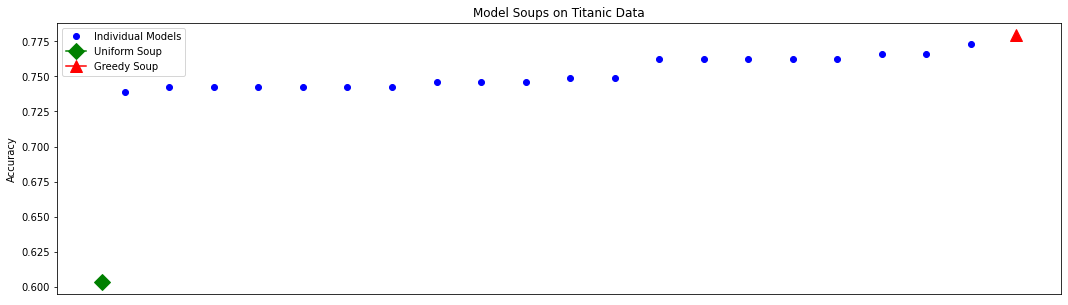

In [16]:
uniform_soup_pos = titanic_params[titanic_params["scores"].values[::-1] > uniform_soup_acc].index[0] - 0.5

fig, ax = plt.subplots(figsize = (18,5))
plt.plot( titanic_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( uniform_soup_pos,uniform_soup_acc,  marker= "D", color = "green", markersize = 12, label = "Uniform Soup")
plt.plot( len(titanic_params), greedy_soup_acc,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("Accuracy")
plt.title("Model Soups on Titanic Data")
plt.legend();

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Soups on Text Data</span></center> 
<a id="7"></a>

#### For Text data, Top 20 Play Store App reviews dataset is used. Sentiment analysis will be done andt target variable will be  binary .
#### Link to Top 20 Play Store App reviews dataset - https://www.kaggle.com/datasets/odins0n/top-20-play-store-app-reviews-daily-update

## <span style="color:#e76f51;"> Setting up TF.data Pipeline  : </span>

In [17]:
## loading data
data = pd.read_csv("../input/top-20-play-store-app-reviews-daily-update/all_combined.csv")
data.dropna(inplace = True)

## filtering only Facebook App Reviews
reviews = data[data["app"] == "Facebook"]

## converting review scores to binary target
reviews["score"] = reviews["score"].map(lambda x: 0 if x<=3 else 1 )


class text_config:
    MODEL_NAME = "distilbert-base-uncased"
    TOKENIZER_NAME = "distilbert-base-uncased"
    MAX_LEN = 64
    BATCH_SIZE = 128
    LOWER_CASE = True
    RANDOM_STATE = 12
    TEST_SIZE = 0.2
    NUM_MODELS = 10


In [18]:
## Hugging Face Dataset API to tokenize data
dataset = Dataset.from_pandas(reviews)
dataset = dataset.rename_columns({"score": "label"})
dataset = dataset.remove_columns(["reviewId", "app"])
dataset = dataset.train_test_split(test_size = text_config.TEST_SIZE, seed = text_config.RANDOM_STATE )
reviews_test_labels = dataset["test"]["label"]

## Instantiating Tokenizer
tokenizer = AutoTokenizer.from_pretrained(text_config.MODEL_NAME, do_lower_case = text_config.LOWER_CASE)

def tokenize(batch):
    return tokenizer(batch["content"], max_length = text_config.MAX_LEN, padding=True, truncation=True)


## tokenizing data
dataset = dataset.map(tokenize)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, 
                                        padding = "max_length",
                                        max_length = text_config.MAX_LEN,
                                        return_tensors="tf")

## Converting huggingface datasets to tfds
train_ds = dataset["train"].to_tf_dataset( 
    columns = ["input_ids", "attention_mask"],
    label_cols = ["labels"],
    batch_size = text_config.BATCH_SIZE,
    collate_fn= data_collator,
    shuffle = True
)

## Converting huggingface datasets to tfds
test_ds = dataset["test"].to_tf_dataset(
    columns = ["input_ids", "attention_mask"],
    label_cols = ["labels"],
    batch_size = text_config.BATCH_SIZE,
    collate_fn= data_collator,
    shuffle = False
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

## <span style="color:#e76f51;"> Text Data Training : </span>

In [19]:
def create_reviews_model():
    """
    Returns Transformer Model ( Tensorflow )
    """    
    input_ids = tf.keras.layers.Input(
            shape=(text_config.MAX_LEN), name="input_ids", dtype=tf.int64
        )
    attention_masks = tf.keras.layers.Input(
                shape=(text_config.MAX_LEN), name="attention_mask", dtype=tf.int64
            )
    
    ## dowloading pretrained wieghts from huggingface 
    bert = TFAutoModel.from_pretrained(text_config.MODEL_NAME)
    out = bert(input_ids,attention_masks)[0]
    out = tf.keras.layers.Dropout(0.3)(out)
    out = tf.keras.layers.Dense(1024)(out)
    out = tf.keras.layers.Dropout(0.3)(out)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(out)

    model = tf.keras.models.Model(
                    inputs=[input_ids, attention_masks], outputs=out            
                )
    return model

def reviews_training(train_ds, 
                   test_ds,
                   epochs, 
                   learning_rate, 
                   weight_decay,
                   save_dir = "reviews/"):
    """
    Returns Saved trained model's path and test evaluation score
    Args:
    train_ds : Train Dataset in tfds format.
    test_ds : Test Dataset in tfds format.
    epochs : Int, Trainig Epochs count.
    learning_rate : Float, Training Learning Rate
    weight_decay : Float, AdamW optimizer Weight Decay
    save_dir : Str, Model Save Directory Prefix
    """
    ## Creating directory for saving models
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    ## AdamW Optimizer Setup 
    adamw_optimizer = tfa.optimizers.AdamW(weight_decay= weight_decay,
                                     learning_rate= learning_rate)
    
    ## Instantiating model
    model = create_reviews_model()
    
    ## Compiling Model
    model.compile(
            optimizer = adamw_optimizer,
            loss = "binary_crossentropy",
            metrics = ["accuracy"]
        )
    
    ## Training Model
    model.fit(
        train_ds,
        epochs = epochs,
        verbose = 0
    )
    ## Evaluating Model
    test_loss , test_score  = model.evaluate(test_ds, verbose = 1 )
    
    ## Saving Trained Model
    model_save_path = save_dir + "reviews-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + ".h5"
    
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## if model with same parameter already exists
        model_save_path =save_dir +  "reviews-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + str(random.choice(np.arange(0,1000))) +  ".h5"
        model.save_weights(model_save_path)
        
    ## Clearing GPU memory
    
    del model 
    gc.collect()
    return model_save_path, test_score

def reviews_eval(model,test_ds):
    """
    Returns Accuracy of model on test set 
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    model.compile(loss=  "binary_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
    loss, acc = model.evaluate(test_ds, verbose = 0)
    return acc

In [20]:
epochs = [3,4,5]
learning_rate = [1e-5, 2e-5, 5e-5]
weight_decay = [1e-4, 1e-5, 2e-5]


## Creating parameters dictonary for 
## hyperparameter tuning 
parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
} for count in range(text_config.NUM_MODELS)]

## creating a dataframe for parameters
reviews_params = pd.DataFrame(parameters)

model_paths = []
test_scores = []


## Training models with different parameters
for params in tqdm(parameters):
    model_save_path, test_score = reviews_training(train_ds, 
                                                   test_ds,
                                                 params["epochs"], 
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 save_dir = "reviews/")
    
    model_paths.append(model_save_path)
    test_scores.append(test_score)
    
## saving scores and model paths to dataframe
reviews_params["paths"] = model_paths
reviews_params["scores"] = test_scores


## soring scores in descending order
reviews_params.sort_values(by = "scores", ascending= False, inplace = True)
reviews_params.reset_index(drop = True, inplace = True)

## saving params with respective scores and model paths
reviews_params.to_csv("review_params.csv", index = False)

  0%|          | 0/10 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-06-22 11:13:01.842693: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


16/16 [==============================] - 4s 147ms/step - loss: 0.4375 - accuracy: 0.8375


## <span style="color:#e76f51;"> Uniform Soups on Text Data: </span>

In [21]:
unifrom_soup_model, uniform_soup_acc = uniform_soup(
    reviews_params["paths"].values, 
    test_ds,
    create_reviews_model,
    reviews_eval
)
print("Accuracy of Uniform Soup:", uniform_soup_acc )

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of Uniform Soup: 0.8225937485694885


## <span style="color:#e76f51;"> Greedy Soups on Text Data: </span>

In [22]:
greedy_soup_model, greedy_soup_acc = greedy_soup(
    reviews_params["paths"].values, 
    test_ds,
    create_reviews_model,
    reviews_eval
)
print("Accuracy of Greedy Soup:", greedy_soup_acc)

  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy of Greedy Soup: 0.8403359651565552


## <span style="color:#e76f51;"> Uniform and Greedy Soups Visualizaiton and Comparison: </span>

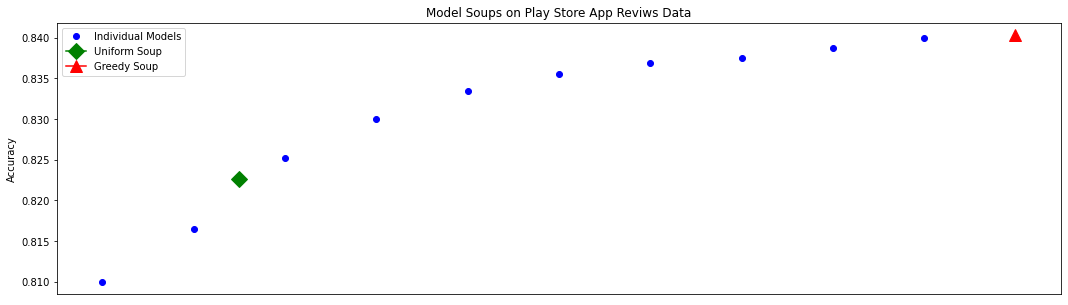

In [23]:
uniform_soup_pos = reviews_params[reviews_params["scores"].values[::-1] > uniform_soup_acc].index[0] - 0.5

fig, ax = plt.subplots(figsize = (18,5))
plt.plot( reviews_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( uniform_soup_pos,uniform_soup_acc,  marker= "D", color = "green", markersize = 12, label = "Uniform Soup")
plt.plot( len(reviews_params), greedy_soup_acc,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("Accuracy")
plt.title("Model Soups on Play Store App Reviws Data")
plt.legend();

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

# <center><span style="color:#00BFC4;"> Model Soups on Time-Series Data</span></center> 
<a id="8"></a>

## <span style="color:#e76f51;"> Setting up TF.data Pipeline  : </span>

##### For Time-Series data, Exchange Rate to USD dataset is used. Time-Series forecasting is done on USD-UK_POUND Exchange pair
##### Link to Exchange Rate to USD dataset  - https://kaggle.com/datasets/robikscube/exhange-rates-to-usd-from-imforg-updated-daily/

In [24]:
## loading data
data = pd.read_csv("../input/exhange-rates-to-usd-from-imforg-updated-daily/exchange_rate_to_usd.csv",
                   parse_dates=["date"]
                  )

## filtering data
dataset = data[["date","uk_pound_to_usd"]]
dataset.dropna(inplace= True)

## Spliting data to train and test split 
test_split = 4* (len(dataset) // 5 )
train_dataset = dataset.iloc[:test_split]
test_dataset = dataset.iloc[test_split:]

class timeseries_config:
    WINDOW_SIZE = 10
    BATCH_SIZE = 128
    SHUFFLE_BUFFER = 1024
    NUM_MODELS = 20

In [25]:
def train_windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Returns Prefetched TFDS for train split
    Args:
    series : Array, Train Split values.
    window_size : Int, Window SIze
    batch_size : Int, Batch Size
    shuffle_buffer : Int, Suffle Buffer for shuffling train split
    """
    ## loading data from numpy arrays/ list
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    ## Crearting windows of "window_size"
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    ## Shuffling data and seperating inputs and ouputs
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    
    ## Batchin and prefetching data
    dataset = dataset.batch(batch_size, drop_remainder= True).prefetch(1)
    return dataset

def test_windowed_dataset(series, window_size, batch_size):
    """
    Returns Prefetched TFDS for test split
    Args:
    series : Array, Train Split values.
    window_size : Int, Window SIze
    batch_size : Int, Batch Size
    """
    
    ## loading data from numpy arrays/ list
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    ## Crearting windows of "window_size"
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    ## Serating inputs and ouputs
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batchin and prefetching data
    dataset = dataset.batch(batch_size, drop_remainder= False).prefetch(1)
    return dataset


train_dataset = train_windowed_dataset(
    train_dataset["uk_pound_to_usd"].values,
    timeseries_config.WINDOW_SIZE,
    timeseries_config.BATCH_SIZE,
    timeseries_config.SHUFFLE_BUFFER
)

test_dataset = test_windowed_dataset(
    test_dataset["uk_pound_to_usd"].values,
    timeseries_config.WINDOW_SIZE,
    timeseries_config.BATCH_SIZE,
)
usd_test_labels = next(iter(test_dataset.unbatch().map(lambda x,y:y).batch(918))).numpy()

## <span style="color:#e76f51;"> Time-Series Data Training : </span>

In [26]:
def create_usd_model(dropout_prob = 0):
    """
    Returns TensorFlow DNN Model
    Args:
    dropout_prob : Dropout Probability for Dropout Layers
    """    
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape = (10)))
    model.add(tf.keras.layers.Dense(512,activation='relu' ))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.Dense(1))
    return model


def usd_training(train_ds, 
                   test_ds,
                   epochs, 
                   learning_rate, 
                   weight_decay,
                   save_dir = "usd/"):
    """
    Returns Saved trained model's path and test evaluation score
    Args:
    train_ds : Train Dataset in tfds format.
    test_ds : Test Dataset in tfds format.
    epochs : Int, Trainig Epochs count.
    learning_rate : Float, Training Learning Rate
    weight_decay : Float, AdamW optimizer Weight Decay
    save_dir : Str, Model Save Directory Prefix
    """
    ## Creating directory for saving models
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    ## AdamW Optimizer Setup 
    adamw_optimizer = tfa.optimizers.AdamW(weight_decay= weight_decay,
                                     learning_rate= learning_rate)
    
    ## Instantiating model
    model = create_usd_model()
    
    ## Compiling Model
    model.compile(
            optimizer = adamw_optimizer,
            loss = "mse",
            metrics = ["mae"]
        )
    
    ## Training Model
    model.fit(
        train_ds,
        epochs = epochs,
        verbose = 0
    )
    ## Evaluating Model
    test_loss , test_score  = model.evaluate(test_ds, verbose = 1 )
    
    ## Saving Trained Model
    model_save_path = save_dir + "usd-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + ".h5"
    
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## if model with same parameter already exists
        model_save_path = save_dir + "usd-" +  str(epochs) + "_" + str(learning_rate) +  "_" + str(weight_decay) + str(random.choice(np.arange(0,1000))) +  ".h5"
        model.save_weights(model_save_path)
        
    ## Clearing GPU memory
    del model 
    gc.collect()
    return model_save_path, test_score

def usd_eval(model,test_ds):
    """
    Returns Accuracy of model on test set 
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    preds = model.predict(test_ds)
    mae = mean_absolute_error(usd_test_labels, preds)
    return mae

In [27]:
epochs = [2,3,4]
learning_rate = [1e-2, 1e-3, 5e-3]
weight_decay = [1e-5, 2e-5, 5e-5]


## Creating parameters dictonary for 
## hyperparameter tuning 
parameters = [ {
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay" : random.choice(weight_decay) ,
} for count in range(timeseries_config.NUM_MODELS)]

## creating a dataframe for parameters
usd_params = pd.DataFrame(parameters)

model_paths = []
test_scores = []


## Training models with different parameters
for params in tqdm(parameters):
    model_save_path, test_score = usd_training(train_dataset,
                                                 test_dataset,
                                                 params["epochs"], 
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 save_dir = "usd/")
    
    model_paths.append(model_save_path)
    test_scores.append(test_score)
    
## saving scores and model paths to dataframe
usd_params["paths"] = model_paths
usd_params["scores"] = test_scores


## soring scores in ascending order ( lower mae)
usd_params.sort_values(by = "scores", ascending= True, inplace = True)
usd_params.reset_index(drop = True, inplace = True)

## saving params with respective scores and model paths
usd_params.to_csv("usd_params.csv", index = False)

  0%|          | 0/20 [00:00<?, ?it/s]

8/8 [==============================] - 0s 15ms/step - loss: 2.3428e-04 - mae: 0.0112


## <span style="color:#e76f51;"> Uniform Soups on Time-Series Data: </span>

In [28]:
unifrom_soup_model, uniform_soup_mae = uniform_soup(
    usd_params["paths"].values, 
    test_dataset,
    create_usd_model,
    usd_eval
)
print("MAE of Uniform Soup:", uniform_soup_mae )

  0%|          | 0/20 [00:00<?, ?it/s]

MAE of Uniform Soup: 1.2976668282356052


## <span style="color:#e76f51;"> Greedy Soups on Time-Series Data: </span>

In [29]:
## mae/mse score version of greedy soup
def greedy_soup_mae(model_paths, test_ds, model_fun, evaluate_fun):
    """
    Returns Greedy Soup model and mae on test set (for time series/ regression data)
    Args:
    model_paths : List, List of saved model paths
    test_ds : Test Dataset in tfds format.
    model_fun : Fun, Model Instantiating Function
    evaluate_fun : Fun, Model Test Set Evaluation Function
    """
    ## Creating intial soup with best performing model 
    soups =  [model_paths[0]]
    
    ## Instantiating model
    
    tf.keras.backend.clear_session()
    model = model_fun()
    
    ## Loading best performing model's weights 
    model.load_weights(model_paths[0])
    
    ## Scoirng best performing model on test set 
    score_final = evaluate_fun(model,test_ds)
    
    ## Iterating over the remaining models 
    for path in tqdm(model_paths[1:]):
        
        ## Creating a temp soup 
        temp_soup =  soups.copy()
        temp_soup.append(path)
        
        ## Getting score from temp soup
        model, score = uniform_soup(temp_soup,test_ds,model_fun, evaluate_fun, disable_tqdm= True)
        
        ## Conditioning current model for appneding in main soup
        ## if score from the temp soup is more than best perofming model
        ## the temp soup path is appended to main soup 
        if score < score_final:
            score_final = score
            soups.append(path)

    return model, score_final

In [30]:
greedy_soup_model, greedy_soup_mae = greedy_soup_mae(
    usd_params["paths"].values, 
    test_dataset,
    create_usd_model,
    usd_eval
)
print("MAE of Greedy Soup:", greedy_soup_mae)

  0%|          | 0/19 [00:00<?, ?it/s]

MAE of Greedy Soup: 0.010873083374602566


## <span style="color:#e76f51;"> Uniform and Greedy Soups Visualizaiton and Comparison: </span>

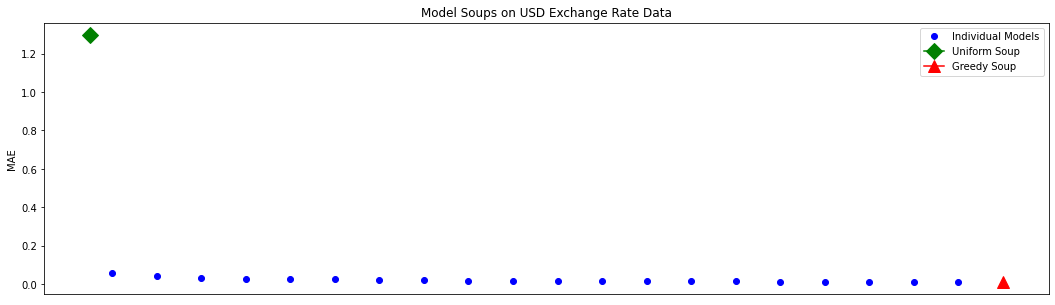

In [31]:
uniform_soup_pos = usd_params[usd_params["scores"].values[::-1] < uniform_soup_mae].index[0] - 0.5

fig, ax = plt.subplots(figsize = (18,5))
plt.plot( usd_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( uniform_soup_pos,uniform_soup_mae,  marker= "D", color = "green", markersize = 12, label = "Uniform Soup")
plt.plot( len(usd_params), greedy_soup_mae,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("MAE")
plt.title("Model Soups on USD Exchange Rate Data")
plt.legend();

<a href="#toc" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

## <span style="color:#00BFC4;"> References  : </span>

https://arxiv.org/abs/2203.05482

https://paperswithcode.com/paper/model-soups-averaging-weights-of-multiple

https://github.com/mlfoundations/model-soups

https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data

https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial

https://www.kaggle.com/code/odins0n/titanic-27-different-models-comparison

https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_1_features_and_labels.ipynb

https://www.kaggle.com/code/odins0n/play-store-reviews-starter-sentiment-analysis


    
### <center>Thank you for reading🙂</center><br>
### <center>If you have any feedback, please let me know!</center><br>
